## P10 - Mateusz Zagórski 313509


In [326]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eig
import networkx as nx
import matplotlib.pyplot as plt
import re
import os


def load_adjacency_matrix(file_path):
    return pd.read_csv(file_path, header=None).values


def spectral_clustering(adj_matrix, num_clusters):
    # laplacian matrix
    laplacian_matrix, _ = laplacian(adj_matrix, normed=True, return_diag=True)

    # eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eig(laplacian_matrix)

    # top 'num_clusters' eigenvectors
    idx = np.argsort(eigenvalues)[:num_clusters]
    selected_vectors = eigenvectors[:, idx].real

    # normalization
    norm_vectors = selected_vectors / np.linalg.norm(
        selected_vectors, axis=1, keepdims=True
    )

    # k-Means on normalized eigenvectors
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(norm_vectors)

    return labels


def visualize_graph(adj_matrix, labels):
    G = nx.from_numpy_array(adj_matrix)
    pos = nx.spring_layout(G)  # Position nodes using spring layout
    nx.draw(G, pos, node_color=labels, with_labels=True, cmap=plt.cm.rainbow)
    plt.show()


def find_cluster_number(file_name):
    res = re.search(r"-K=(.+?)", file_name)
    if file_name[res.span()[1]] != ".":
        return int(file_name[res.span()[1] - 1] + file_name[res.span()[1]])
    else:
        return int(file_name[res.span()[1] - 1])


def save_results(file_name, nodes_mapping):
    print(nodes_mapping)
    mapping = {}
    if type(nodes_mapping[0]) == set:
        for index, nodes in enumerate(nodes_mapping):
            mapping[index] = nodes
        nodes_dict = {}
        for cluster, nodes in mapping.items():
            for node in nodes:
                nodes_dict[node] = cluster
        nodes_mapping = []
        nodes_arr = list(nodes_dict.keys())
        nodes_arr.sort()
        for node in nodes_arr:
            nodes_mapping.append(nodes_dict[node])
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    with open(file_name, mode="w") as file:
        for index, cluster in enumerate(nodes_mapping):
            file.write(f"{index + 1}, {cluster + 1}\n")

known k=2:


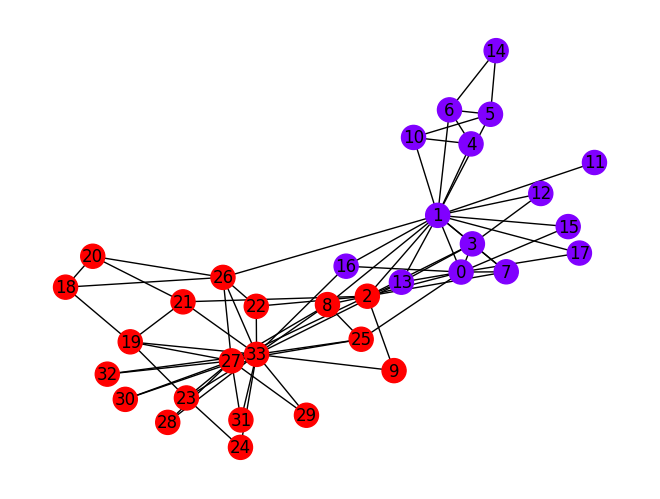

[0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
known k=7:


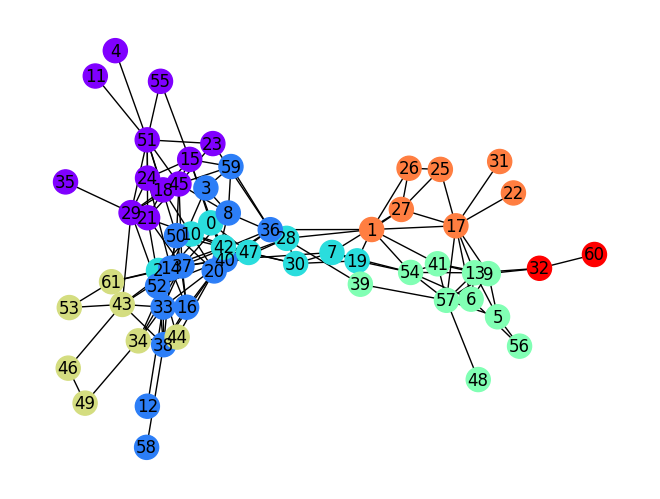

[2 5 2 1 0 3 3 2 1 3 2 0 1 3 1 0 1 5 0 2 1 0 5 0 0 5 5 5 2 0 2 5 6 1 4 0 1
 1 1 3 1 3 2 4 4 0 4 2 3 4 1 0 1 4 3 0 3 3 1 1 6 4]
known k=12:


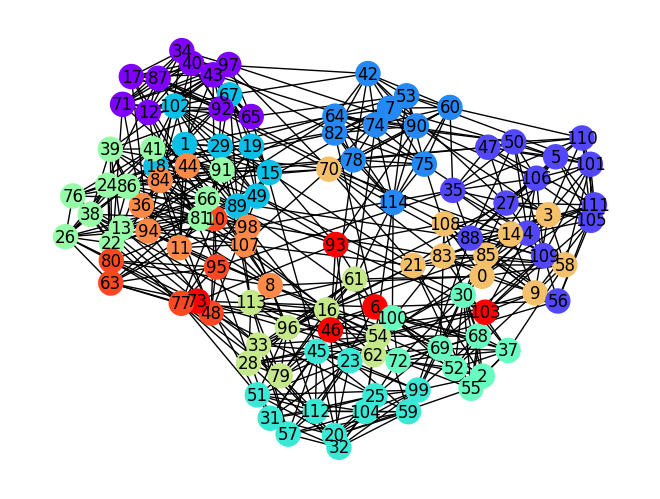

[ 8  3  5  8  1  1 11  2  9  8 10  9  0  6  8  3  7  0  3  3  4  8  6  4
  6  4  6  1  7  3  5  4  4  7  0  1  9  5  6  6  0  6  2  0  9  4 11  1
 10  3  1  4  5  2  7  5  1  4  8  4  2  7  7 10  2  0  6  3  5  5  8  0
  5 11  2  2  6 10  2  7 10  6  2  8  9  8  6  0  1  3  2  6  0 11  9 10
  7  0  9  4  5  1  3 11  4  1  1  9  8  1  1  1  4  7  2]


In [328]:
known_data_mapping = {
    "known k=2": "./data/D1-K=2.csv",
    "known k=7": "./data/D2-K=7.csv",
    "known k=12": "./data/D3-K=12.csv",
}

for name in known_data_mapping.keys():
    file_name = known_data_mapping[name]
    graph = load_adjacency_matrix(file_name)
    print(f"{name}:")

    num_clusters = find_cluster_number(file_name)
    node_mapping = spectral_clustering(graph, num_clusters)

    visualize_graph(graph, node_mapping)

    save_results(file_name.replace("data", "mateusz_zagorski"), node_mapping)

In [287]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import matplotlib.pyplot as plt

# the lower this const, the less clusters are likely to be found
CLUSTERING_CONST = 1
NO_EDGE_WEIGHT = 0
# For some reason very small changes in no-edge weight changes result for unknown 1 from 12 clusters to 1 cluster (couldn't calibrate it)
# 0.100909291 - 0.100909293


def load_graph(adj_matrix):
    G = nx.from_numpy_array(adj_matrix)
    return G


def calculate_modularity(graph, communities):
    m = len(graph.edges())  # Total weight of edges
    modularity = 0
    for community in communities.values():
        for u in community:
            for v in community:
                A_uv = 1 if graph.has_edge(u, v) else NO_EDGE_WEIGHT
                k_u = graph.degree[u]  # Degree of node u
                k_v = graph.degree[v]  # Degree of node v
                modularity += A_uv - CLUSTERING_CONST * (k_u * k_v) / (2 * m)
    modularity /= 2 * m
    return modularity


def louvain_clustering(graph):
    node_to_community = {node: node for node in graph.nodes()}
    communities = {node: {node} for node in graph.nodes()}
    current_modularity = calculate_modularity(graph, communities)
    improved = True

    while improved:
        improved = False
        for node in list(graph.nodes()):
            current_community = node_to_community[node]
            best_community = current_community
            best_gain = 0

            communities[current_community].remove(node)
            if not communities[current_community]:
                del communities[current_community]

            # find the best community for the current node
            for neighbor in graph.neighbors(node):
                neighbor_community = node_to_community[neighbor]
                if neighbor_community == current_community:
                    continue
                temp_communities = {key: items for key, items in communities.items()}
                temp_communities[neighbor_community] = temp_communities[
                    neighbor_community
                ] | {node}

                modularity_gain = (
                    calculate_modularity(graph, temp_communities) - current_modularity
                )

                if modularity_gain > best_gain:
                    best_gain = modularity_gain
                    best_community = neighbor_community

            # move node if there's progress, return it to the old community otherwise
            if best_community != current_community:
                improved = True
                current_modularity += best_gain
                if best_community not in communities:
                    communities[best_community] = set()
                communities[best_community].add(node)
                node_to_community[node] = best_community
            else:
                if current_community not in communities:
                    communities[current_community] = set()
                communities[current_community].add(node)

    return list(communities.values())


def visualize_clusters(graph, communities):
    pos = nx.spring_layout(graph)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))

    for community, color in zip(communities, colors):
        nx.draw_networkx_nodes(
            graph,
            pos,
            nodelist=community,
            node_color=[color],
        )

    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    nx.draw_networkx_labels(graph, pos)
    plt.show()

unknown 1 - 25 clusters found: 


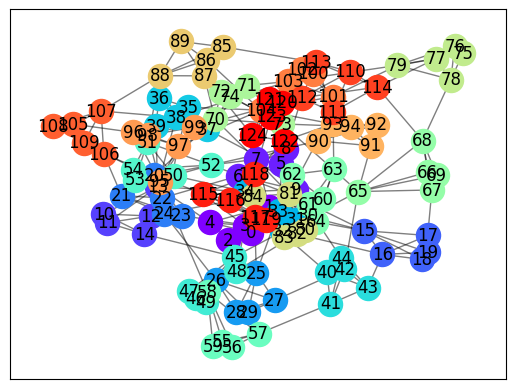

[{0, 1, 2, 3, 4}, {5, 6, 7, 8, 9}, {10, 11, 12, 13, 14}, {15, 16, 17, 18, 19}, {20, 21, 22, 23, 24}, {25, 26, 27, 28, 29}, {32, 33, 34, 30, 31}, {35, 36, 37, 38, 39}, {40, 41, 42, 43, 44}, {45, 46, 47, 48, 49}, {50, 51, 52, 53, 54}, {55, 56, 57, 58, 59}, {64, 60, 61, 62, 63}, {65, 66, 67, 68, 69}, {70, 71, 72, 73, 74}, {75, 76, 77, 78, 79}, {80, 81, 82, 83, 84}, {85, 86, 87, 88, 89}, {90, 91, 92, 93, 94}, {96, 97, 98, 99, 95}, {100, 101, 102, 103, 104}, {105, 106, 107, 108, 109}, {110, 111, 112, 113, 114}, {115, 116, 117, 118, 119}, {120, 121, 122, 123, 124}]
unknown 2 - 15 clusters found: 


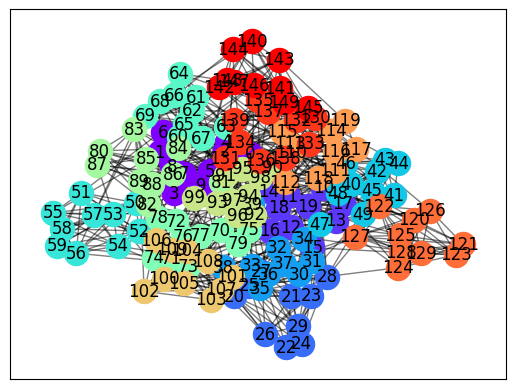

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, {10, 11, 12, 13, 14, 15, 16, 17, 18, 19}, {20, 21, 22, 23, 24, 25, 26, 27, 28, 29}, {33, 34, 35, 36, 37, 38, 39, 32, 30, 31}, {40, 41, 42, 43, 44, 45, 46, 47, 48, 49}, {50, 51, 52, 53, 54, 55, 56, 57, 58, 59}, {64, 65, 66, 67, 68, 69, 60, 61, 62, 63}, {70, 71, 72, 73, 74, 75, 76, 77, 78, 79}, {80, 81, 82, 83, 84, 85, 86, 87, 88, 89}, {96, 97, 98, 99, 90, 91, 92, 93, 94, 95}, {100, 101, 102, 103, 104, 105, 106, 107, 108, 109}, {110, 111, 112, 113, 114, 115, 116, 117, 118, 119}, {128, 129, 120, 121, 122, 123, 124, 125, 126, 127}, {130, 131, 132, 133, 134, 135, 136, 137, 138, 139}, {140, 141, 142, 143, 144, 145, 146, 147, 148, 149}]
unknown 3 - 9 clusters found: 


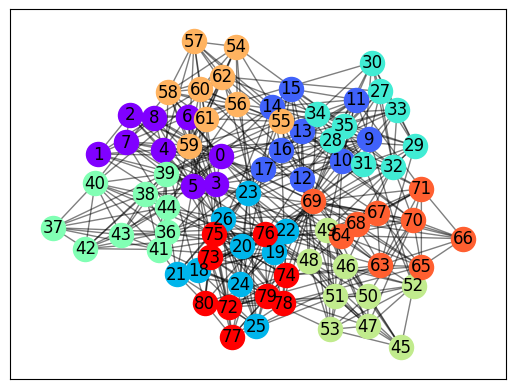

[{0, 1, 2, 3, 4, 5, 6, 7, 8}, {9, 10, 11, 12, 13, 14, 15, 16, 17}, {18, 19, 20, 21, 22, 23, 24, 25, 26}, {32, 33, 34, 35, 27, 28, 29, 30, 31}, {36, 37, 38, 39, 40, 41, 42, 43, 44}, {45, 46, 47, 48, 49, 50, 51, 52, 53}, {54, 55, 56, 57, 58, 59, 60, 61, 62}, {64, 65, 66, 67, 68, 69, 70, 71, 63}, {72, 73, 74, 75, 76, 77, 78, 79, 80}]


In [329]:
unknown_data_mapping = {
    "unknown 1": "./data/D1-UNC.csv",
    "unknown 2": "./data/D2-UNC.csv",
    "unknown 3": "./data/D3-UNC.csv",
}

for name, file_name in unknown_data_mapping.items():
    graph = load_adjacency_matrix(file_name)
    G = load_graph(graph)

    node_mapping = louvain_clustering(G)
    print(f"{name} - {len(node_mapping)} clusters found: ")

    visualize_clusters(G, node_mapping)

    save_results(file_name.replace("data", "mateusz_zagorski"), node_mapping)